### Introduction
Briefly describe the project, its objectives, and the dataset you will use.

### Setup and Imports
Import necessary libraries (`tensorflow`, `numpy`, `matplotlib`, etc.).

In [61]:
'''Setup and Imports'''
import numpy as np
import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# If the warning persists, you might try using the legacy optimizer as follows:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras import layers, models # for defining the generator and discriminator networks
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization
from PIL import Image # for loading images
import matplotlib.image as mpimg # for loading images
import matplotlib.pyplot as plt
import pandas as pd # for data visualization
import sklearn # for any additional machine learning utilities
from sklearn.preprocessing import MultiLabelBinarizer # for one-hot encoding of ingredient labels
from sklearn.model_selection import train_test_split # for splitting the dataset
import skimage # for image processing
from skimage.transform import resize
from skimage.io import imread
import os

### Dataset Loading and Preprocessing
- Load your dataset of smoothie images.
- Preprocess images (resizing, normalization).
- Split the dataset into training and testing sets.

This code combines loading, preprocessing, encoding, and splitting into a single cell, ensuring that `X_train`, `X_val`, `y_train`, and `y_val` are properly defined and available for training and validation.

In [62]:
'''Dataset Loading and Preprocessing'''
# Define the path to your JSON file
# dataset_path = 'datasets/smoothies.json'
file_path = '/Users/brandiellenkinard/Documents/000-smoothie-ingredients/myproject/smoothie-cGAN/datasets/datasets/smoothies.json'

# Load the dataset
dataset = pd.read_json(file_path)

# Normalization helps the model learn more efficiently. This is important for neural network training, because it helps with the convergence of the model.
# Pixel values range from 0 to 255, so dividing by 255 will scale them to the [0,1] range, which is common and works well for most models.
def preprocess_image(image_path, target_size=(128, 128)):
    # Ensure the full path is correctly constructed from the notebook's location
    full_image_path = os.path.abspath(image_path)
    try:
        with Image.open(full_image_path) as img:
            # Rest of your preprocessing code here
            img = img.convert('RGBA')  # Convert to RGBA to handle transparency
            canvas = Image.new('RGBA', img.size, "WHITE")  # Create a white canvas
            canvas.paste(img, mask=img.split()[3])  # Paste using alpha channel as mask
            img = canvas.convert('RGB')  # Convert back to RGB
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize pixel values
        return img
    except IOError as e:
        print(f"Error opening or processing image {full_image_path}: {e}")
        return None

# Correctly update image paths relative to the notebook's current directory
dataset['image'] = dataset['image'].apply(lambda x: os.path.join('..', 'datasets', x))

# Preprocess images and convert them into an array X
# Ensure that only existing paths are passed to the preprocessing function
X = np.array(dataset['image'].apply(preprocess_image).tolist())

# Encode ingredient labels
unique_ingredients = set(item for sublist in dataset['ingredients'] for item in sublist)
mlb = MultiLabelBinarizer(classes=sorted(unique_ingredients))
y = mlb.fit_transform(dataset['ingredients'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

image_shape = (128, 128, 3)  # After preprocessing images
num_tags = y.shape[1]  # Number of unique tags

### Data Augmentation
- Implement data augmentation techniques to diversify your training dataset and improve model robustness.

In [63]:
'''Data Augmentation'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=20,      # Random rotations. Random rotation between 0 and 10 degrees. Used to be 10
    width_shift_range=0.2,  # Random horizontal shifts. Fraction of total width for horizontal shift. Used to be 0.1
    height_shift_range=0.2, # Random vertical shifts. Fraction of total height for vertical shift. Used to be 0.1
    shear_range=0.15,        # Shear transformations. Used to be 0.1
    zoom_range=0.2,         # Random zoom. Random zoom between 90% (0.9) and 110% (1.1). Used to be 0.1
    channel_shift_range=30, # Add channel shifting for color variation
    vertical_flip=True,     # Add vertical flips for more variability
    horizontal_flip=True,   # Horizontal flips. Randomly flip inputs horizontally. 
    fill_mode='reflect'     # Fill strategy. Strategy for filling in newly created pixels. Used to be nearest
)

### Model 
- Define the diffusion model architecture. This can be challenging without specific code examples for diffusion models, as they are complex and involve nuanced implementation details. You might start with simpler generative models to gain more experience.
In a diffusion model, you typically need two main components: the model that predicts the noise (often a U-Net architecture for images), and the diffusion process itself which involves a series of forward (noising) and reverse (denoising) steps.
- U-Net Architecture for Images: This CNN architecture is effective for tasks that require understanding the context of the entire image, such as generating or denoising images. It consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

In [64]:
'''Model Architecture'''
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    
    # Upsample
    u4 = UpSampling2D((2, 2))(c3)
    u4 = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same')(u4)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same')(u5)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Output layer
    output = Conv2D(3, (1, 1), activation='tanh')(c5)
    
    return Model(inputs=inputs, outputs=output)


### Training Setup
- Define the loss functions, optimizers, and training loop.
- Implement the forward and reverse processes of the diffusion model.

Implemented in the following cell:
- Diffusion Process: involves defining the forward process (adding noise) and the reverse process (model learning to reverse the noising process)
- Loss Function: a mean squared error (MSE) between the original images and the reconstructed images
- Optimizer: Adam optimizer

In [65]:
'''Training Setup'''
# Assuming 'unet_model' is your U-Net model function from the previous cell
model = unet_model(input_size=(128, 128, 3))

# Loss function
loss_function = MeanSquaredError()

# Optimizer
optimizer = Adam(learning_rate=5e-4) # used to be `1e-4` (0.0001)

model.compile(optimizer=optimizer, loss=loss_function)

# Forward process - Adding noise
def add_noise(images, noise_factor=0.1):
    """
    Adds Gaussian noise to each image.
    """
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, -1.0, 1.0)  # Ensure the images are still in [-1, 1]
    return noisy_images

# Reverse process - This is implicitly learned by the model during training
# by trying to reconstruct the original images from the noisy images.



### Training Execution
- Run the training loop, periodically saving generated images to monitor progress.

Inluced in the following cell:
- Iterate over epochs
- In each epoch, run the forward diffusion process to add noise to the images, then run the reverse process where the model learns to reconstruct the original images from the noised images
- Update the model weights based on the loss between the reconstructed images and the original images

This code snippet includes the training loop where:
- Noise is added to the original images to simulate the forward diffusion process.
- The model learns to reconstruct the original images from their noisy counterparts.
- Training loss is recorded and printed at the end of each epoch.
- Sample images (original, noisy, and reconstructed) are displayed at specified intervals to visually assess the model's performance.
- Training loss is plotted over epochs to visualize the learning progress.

2024-03-03 05:45:04.666943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:05.634472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 1, Loss: 0.189679354429245


2024-03-03 05:45:06.220305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:06.786246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 2, Loss: 0.12309890240430832


2024-03-03 05:45:07.351288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:07.953945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 3, Loss: 0.1320175789296627


2024-03-03 05:45:08.558993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:09.174483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 4, Loss: 0.09888523817062378


2024-03-03 05:45:09.782407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:10.360951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 5, Loss: 0.11214752122759819


2024-03-03 05:45:10.935003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:11.526278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 6, Loss: 0.14354956150054932


2024-03-03 05:45:12.131583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:12.721366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 7, Loss: 0.0906844325363636


2024-03-03 05:45:13.334836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:13.951432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 8, Loss: 0.10608236491680145


2024-03-03 05:45:14.610178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:15.224603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 9, Loss: 0.10036642104387283


2024-03-03 05:45:15.821063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:16.403143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 10, Loss: 0.07278307527303696
1/1 [==============================] - 0s 221ms/step


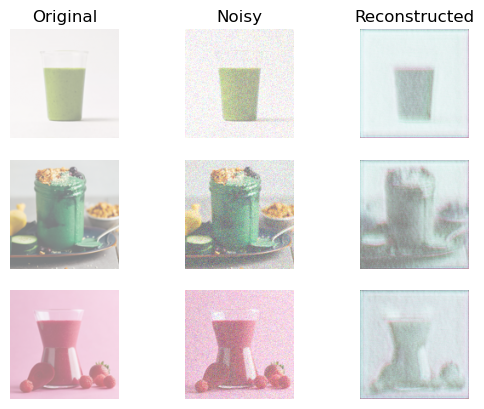

2024-03-03 05:45:17.440245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:18.066862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 11, Loss: 0.06488585844635963


2024-03-03 05:45:18.684193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:19.266664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 12, Loss: 0.06695086881518364


2024-03-03 05:45:19.888646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:20.499139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 13, Loss: 0.054485900327563286


2024-03-03 05:45:21.096661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:21.657699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 14, Loss: 0.0427006259560585


2024-03-03 05:45:22.220579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:22.767120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 15, Loss: 0.04484545812010765


2024-03-03 05:45:23.347856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:23.948662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 16, Loss: 0.03742869570851326


2024-03-03 05:45:24.558248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:25.170998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 17, Loss: 0.035902226343750954


2024-03-03 05:45:25.772626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:26.366380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 18, Loss: 0.04036937281489372


2024-03-03 05:45:26.926830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:27.474411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 19, Loss: 0.03408938832581043


2024-03-03 05:45:28.030975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:28.642865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 20, Loss: 0.03296523820608854
1/1 [==============================] - 0s 159ms/step


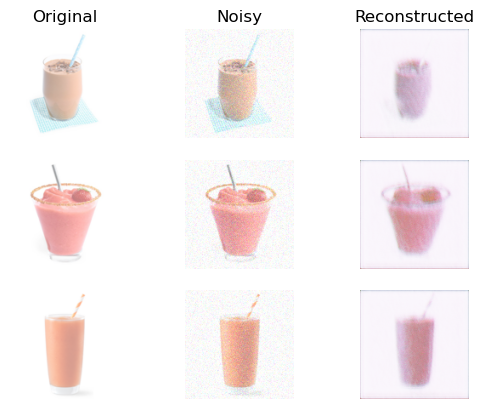

2024-03-03 05:45:29.526955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:30.260066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 21, Loss: 0.026754869148135185


2024-03-03 05:45:30.954622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:31.561728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 22, Loss: 0.030443843454122543


2024-03-03 05:45:32.203414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:32.837555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 23, Loss: 0.027731827460229397


2024-03-03 05:45:33.465468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:34.048894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 24, Loss: 0.027791105210781097


2024-03-03 05:45:34.603669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:35.168864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 25, Loss: 0.025453069247305393


2024-03-03 05:45:35.786404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:36.457932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 26, Loss: 0.02548043243587017


2024-03-03 05:45:37.087909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:37.855321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 27, Loss: 0.026052306406199932


2024-03-03 05:45:38.500836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:39.094669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 28, Loss: 0.020220867358148098


2024-03-03 05:45:39.720341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:40.323535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 29, Loss: 0.02217339724302292


2024-03-03 05:45:41.000848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:41.583694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 30, Loss: 0.019903033040463924
1/1 [==============================] - 0s 172ms/step


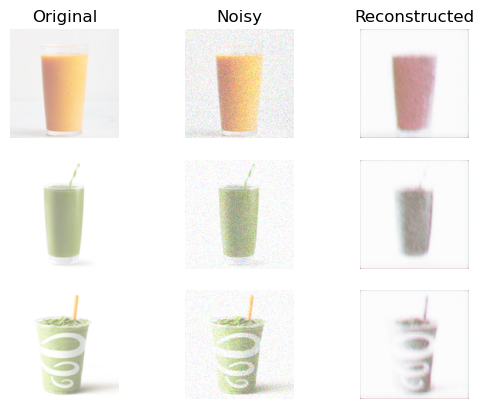

2024-03-03 05:45:42.679791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:43.337223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 31, Loss: 0.02261707466095686


2024-03-03 05:45:43.952630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:44.533312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 32, Loss: 0.019792635925114155


2024-03-03 05:45:45.100491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:45.665497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 33, Loss: 0.02036887127906084


2024-03-03 05:45:46.276607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:46.863503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 34, Loss: 0.018237004056572914


2024-03-03 05:45:47.514100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:48.148729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 35, Loss: 0.018708419054746628


2024-03-03 05:45:48.729525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:49.295673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 36, Loss: 0.019043225795030594


2024-03-03 05:45:49.901994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:50.539577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 37, Loss: 0.018116355873644352


2024-03-03 05:45:51.168670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:51.759507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 38, Loss: 0.018214057199656963


2024-03-03 05:45:52.379925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:52.974079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 39, Loss: 0.016441173385828733


2024-03-03 05:45:53.572374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:54.144919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 40, Loss: 0.01839891355484724
1/1 [==============================] - 0s 154ms/step


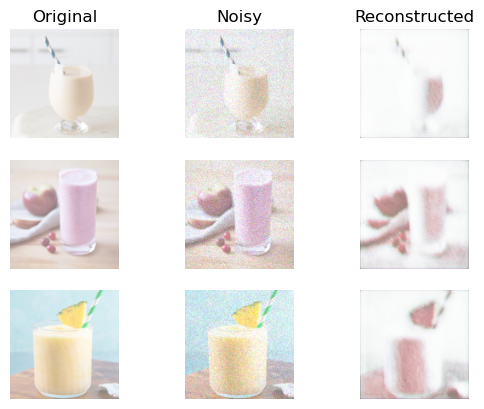

2024-03-03 05:45:55.040991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:55.628891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 41, Loss: 0.01729308208450675


2024-03-03 05:45:56.186925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:56.752552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 42, Loss: 0.015821322798728943


2024-03-03 05:45:57.312724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:57.879201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 43, Loss: 0.01563424151390791


2024-03-03 05:45:58.438760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:45:59.038865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 44, Loss: 0.01605455670505762


2024-03-03 05:45:59.662076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:00.253007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 45, Loss: 0.014987046830356121


2024-03-03 05:46:00.814990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:01.371575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 46, Loss: 0.012209476437419653


2024-03-03 05:46:01.942035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:02.547111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 47, Loss: 0.015775849111378193


2024-03-03 05:46:03.109896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:03.680239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 48, Loss: 0.013330427929759026


2024-03-03 05:46:04.297931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:04.874207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 49, Loss: 0.013448521494865417


2024-03-03 05:46:05.443965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:06.139693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 50, Loss: 0.013380116783082485
1/1 [==============================] - 0s 192ms/step


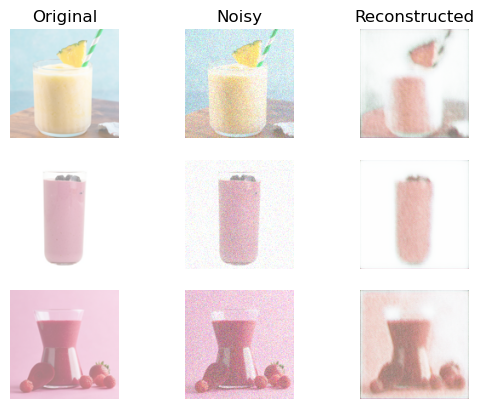

2024-03-03 05:46:07.217600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:07.842926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 51, Loss: 0.013168495148420334


2024-03-03 05:46:08.440998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:09.035875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 52, Loss: 0.011751208454370499


2024-03-03 05:46:09.694904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:10.315828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 53, Loss: 0.01388891413807869


2024-03-03 05:46:10.955787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:11.557477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 54, Loss: 0.011257806792855263


2024-03-03 05:46:12.245175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:12.809158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 55, Loss: 0.012305709067732096


2024-03-03 05:46:13.369374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:13.935468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 56, Loss: 0.012878336943686008


2024-03-03 05:46:14.494587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:15.054005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 57, Loss: 0.012719495221972466


2024-03-03 05:46:15.621215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:16.243158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 58, Loss: 0.011574514675885439


2024-03-03 05:46:16.869531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:17.477369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 59, Loss: 0.011133899446576834


2024-03-03 05:46:18.089904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:18.683709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 60, Loss: 0.010420638136565685
1/1 [==============================] - 0s 157ms/step


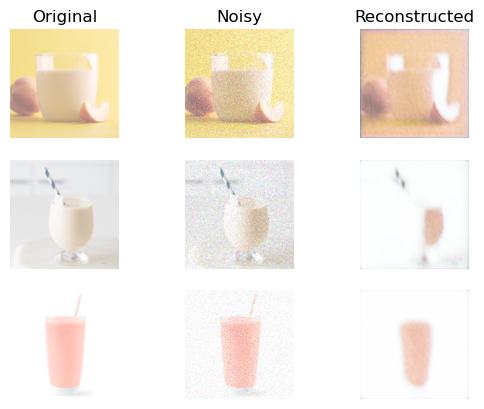

2024-03-03 05:46:19.583077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:20.227853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 61, Loss: 0.009890024550259113


2024-03-03 05:46:20.838493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:21.472826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 62, Loss: 0.010615119710564613


2024-03-03 05:46:22.106385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:22.673729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 63, Loss: 0.0108289890922606


2024-03-03 05:46:23.244600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:23.845194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 64, Loss: 0.012417136691510677


2024-03-03 05:46:24.418230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:24.985232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 65, Loss: 0.01145461993291974


2024-03-03 05:46:25.568178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:26.281578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 66, Loss: 0.009565737564116716


2024-03-03 05:46:27.020157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:27.626155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 67, Loss: 0.011534478981047869


2024-03-03 05:46:28.213507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:28.863157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 68, Loss: 0.010322457645088434


2024-03-03 05:46:29.475383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:30.100364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 69, Loss: 0.010588603559881449


2024-03-03 05:46:30.731314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:31.346307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 70, Loss: 0.010301257483661175
1/1 [==============================] - 0s 173ms/step


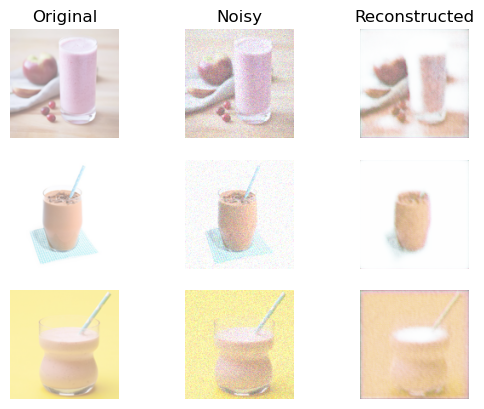

2024-03-03 05:46:32.386716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:32.981920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 71, Loss: 0.009550494607537985


2024-03-03 05:46:33.546347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:34.143065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 72, Loss: 0.010694356169551611


2024-03-03 05:46:34.724573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:35.282811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 73, Loss: 0.010264814365655184


2024-03-03 05:46:35.844769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:36.431915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 74, Loss: 0.009400215465575457


2024-03-03 05:46:36.997706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:37.562188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 75, Loss: 0.009866486769169569


2024-03-03 05:46:38.148859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:38.710993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 76, Loss: 0.009290392510592937


2024-03-03 05:46:39.312322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:39.880350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 77, Loss: 0.009310185443609953


2024-03-03 05:46:40.448817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:41.021783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 78, Loss: 0.00882173446007073


2024-03-03 05:46:41.742928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:42.472918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 79, Loss: 0.008577306987717748


2024-03-03 05:46:43.071083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:43.671336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 80, Loss: 0.008652173448354006
1/1 [==============================] - 0s 190ms/step


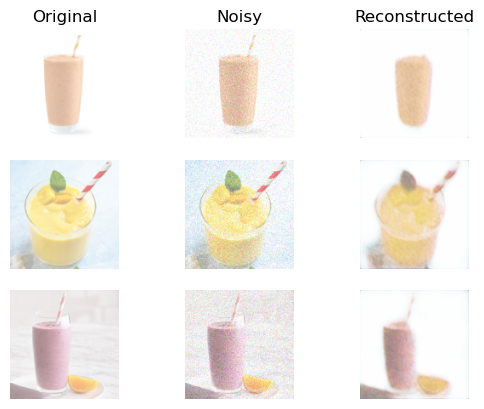

2024-03-03 05:46:44.631003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:45.291863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 81, Loss: 0.00855691684409976


2024-03-03 05:46:45.923666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:46.557236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 82, Loss: 0.010193393100053072


2024-03-03 05:46:47.175375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:47.822885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 83, Loss: 0.007882637437433004


2024-03-03 05:46:48.485761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:49.133047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 84, Loss: 0.008218667469918728


2024-03-03 05:46:49.765038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:50.432424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 85, Loss: 0.00905997445806861


2024-03-03 05:46:51.092195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:51.718202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 86, Loss: 0.007753521203994751


2024-03-03 05:46:52.324849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:52.911039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 87, Loss: 0.007872574497014284


2024-03-03 05:46:53.578407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:54.252013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 88, Loss: 0.00793416379019618


2024-03-03 05:46:55.080119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:55.699959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 89, Loss: 0.009162328671664


2024-03-03 05:46:56.282239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:56.868122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 90, Loss: 0.008587287738919258
1/1 [==============================] - 0s 171ms/step


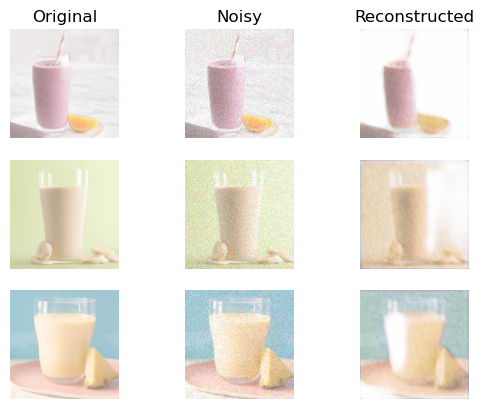

2024-03-03 05:46:57.999619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:58.654680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 91, Loss: 0.008308521937578917


2024-03-03 05:46:59.287466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:46:59.911622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 92, Loss: 0.0076343093533068895


2024-03-03 05:47:00.503214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:01.070347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 93, Loss: 0.0077797777485102415


2024-03-03 05:47:01.655970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:02.238317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 94, Loss: 0.007302945479750633


2024-03-03 05:47:02.818649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:03.401545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 95, Loss: 0.007755539380013943


2024-03-03 05:47:04.023144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:04.634327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 96, Loss: 0.007645968347787857


2024-03-03 05:47:05.208196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:05.785282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 97, Loss: 0.006966992747038603


2024-03-03 05:47:06.383499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:06.963782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 98, Loss: 0.007474229903891683


2024-03-03 05:47:07.540772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:08.121414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 99, Loss: 0.007953334366902709


2024-03-03 05:47:08.686761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:09.267165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 100, Loss: 0.007833316922187805
1/1 [==============================] - 0s 158ms/step


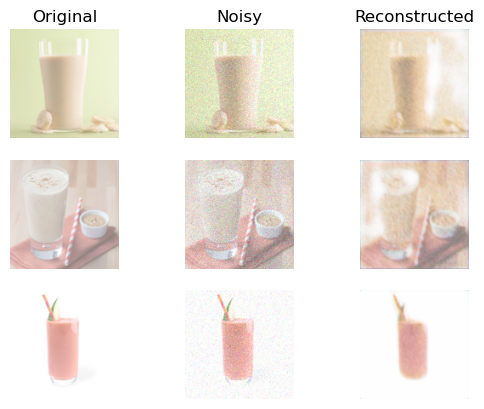

2024-03-03 05:47:10.240414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:10.927110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 101, Loss: 0.007130988873541355


2024-03-03 05:47:11.652008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:12.332826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 102, Loss: 0.007160440785810351


2024-03-03 05:47:12.924050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:13.569494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 103, Loss: 0.00737009197473526


2024-03-03 05:47:14.200915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:14.817697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 104, Loss: 0.007230544462800026


2024-03-03 05:47:15.418045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:16.001121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 105, Loss: 0.007030627457424998


2024-03-03 05:47:16.603369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:17.180087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 106, Loss: 0.006850396282970905


2024-03-03 05:47:17.771797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:18.378833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 107, Loss: 0.0071044862270355225


2024-03-03 05:47:18.992490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:19.620493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 108, Loss: 0.007492130389437079


2024-03-03 05:47:20.243829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:20.869286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 109, Loss: 0.006292849080637097


2024-03-03 05:47:21.502978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:22.127746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 110, Loss: 0.006774809909984469
1/1 [==============================] - 0s 209ms/step


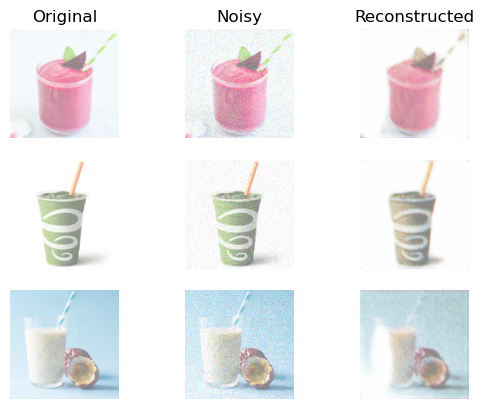

2024-03-03 05:47:23.166764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:23.837075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 111, Loss: 0.006137270480394363


2024-03-03 05:47:24.438713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:25.135789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 112, Loss: 0.006478191586211324


2024-03-03 05:47:25.763584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:26.387552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 113, Loss: 0.007315068272873759


2024-03-03 05:47:27.067645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:27.652650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 114, Loss: 0.00732543203048408


2024-03-03 05:47:28.259337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:28.912113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 115, Loss: 0.006602524314075708


2024-03-03 05:47:29.549961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:30.175704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 116, Loss: 0.006676872493699193


2024-03-03 05:47:30.767387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:31.393052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 117, Loss: 0.006464899983257055


2024-03-03 05:47:32.029531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:32.641911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 118, Loss: 0.006491051055490971


2024-03-03 05:47:33.258489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:33.857002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 119, Loss: 0.006589338881894946


2024-03-03 05:47:34.428541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:34.997008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 120, Loss: 0.00544502935372293
1/1 [==============================] - 0s 163ms/step


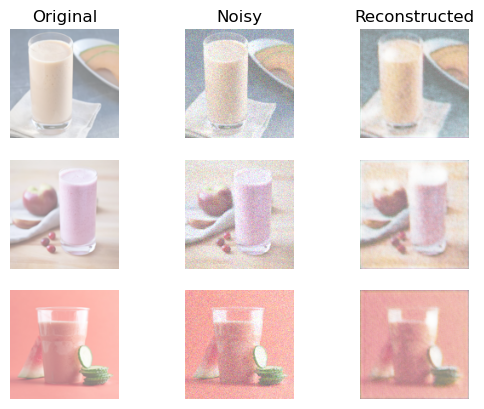

2024-03-03 05:47:35.900260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:36.540196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 121, Loss: 0.005929469130933285


2024-03-03 05:47:37.122921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:37.705849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 122, Loss: 0.006592325167730451


2024-03-03 05:47:38.314759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:38.914475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 123, Loss: 0.006275308318436146


2024-03-03 05:47:39.645627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:40.401341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 124, Loss: 0.005886488826945424


2024-03-03 05:47:41.021589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:41.679829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 125, Loss: 0.006171978777274489


2024-03-03 05:47:42.313496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:42.946648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 126, Loss: 0.005523083498701453


2024-03-03 05:47:43.698294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:44.353107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 127, Loss: 0.006150198867544532


2024-03-03 05:47:44.996693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:45.572381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 128, Loss: 0.005709632532671094


2024-03-03 05:47:46.163414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:46.751767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 129, Loss: 0.005841933656483889


2024-03-03 05:47:47.327938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:47.899751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 130, Loss: 0.005630561383441091
1/1 [==============================] - 0s 161ms/step


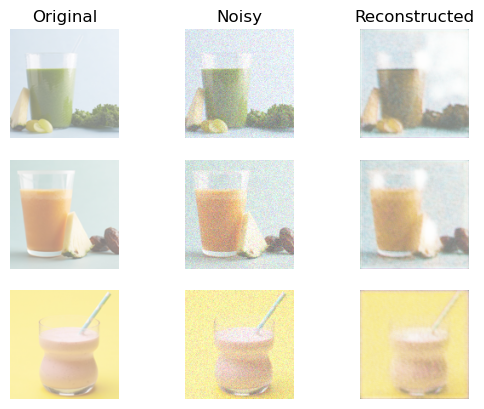

2024-03-03 05:47:48.814122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:49.402721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 131, Loss: 0.005685252603143454


2024-03-03 05:47:49.956329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:50.525424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 132, Loss: 0.005364886252209544


2024-03-03 05:47:51.218444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:51.853243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 133, Loss: 0.005967379081994295


2024-03-03 05:47:52.427411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:53.011778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 134, Loss: 0.005145547213032842


2024-03-03 05:47:53.627574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:54.224045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 135, Loss: 0.00535019370727241


2024-03-03 05:47:54.853555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:55.433707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 136, Loss: 0.005966814700514078


2024-03-03 05:47:56.020613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:56.591867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 137, Loss: 0.005723260808736086


2024-03-03 05:47:57.173475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:57.755085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 138, Loss: 0.005559162236750126


2024-03-03 05:47:58.316733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:47:58.880987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 139, Loss: 0.005367468809708953


2024-03-03 05:47:59.456082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:00.058392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 140, Loss: 0.004877404542639852
1/1 [==============================] - 0s 167ms/step


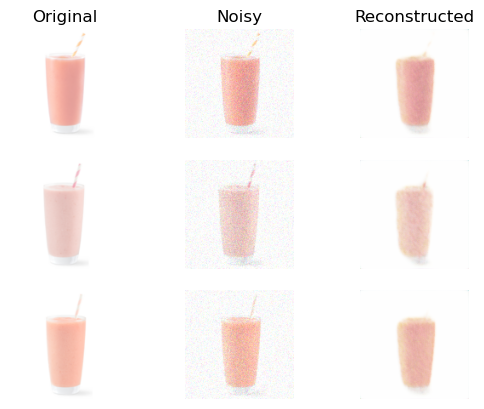

2024-03-03 05:48:00.960045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:01.570169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 141, Loss: 0.005275537259876728


2024-03-03 05:48:02.156486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:02.750757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 142, Loss: 0.005402267212048173


2024-03-03 05:48:03.341234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:03.919214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 143, Loss: 0.005090038059279323


2024-03-03 05:48:04.504124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:05.095415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 144, Loss: 0.005080524366348982


2024-03-03 05:48:05.665602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:06.261747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 145, Loss: 0.004979222314432263


2024-03-03 05:48:06.842642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:07.471491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 146, Loss: 0.005396929103881121


2024-03-03 05:48:08.090958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:08.749911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 147, Loss: 0.004932797281071544


2024-03-03 05:48:09.383008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:10.103996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 148, Loss: 0.004725745180621743


2024-03-03 05:48:10.785503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:11.418678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 149, Loss: 0.00496235559694469


2024-03-03 05:48:12.058207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:12.670409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 150, Loss: 0.004738110350444913
1/1 [==============================] - 0s 160ms/step


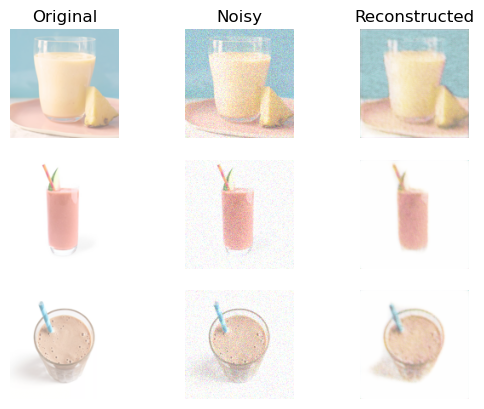

2024-03-03 05:48:13.722399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:14.354780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 151, Loss: 0.005409409524872899


2024-03-03 05:48:14.979580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:15.563891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 152, Loss: 0.00532853021286428


2024-03-03 05:48:16.142363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:16.714445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 153, Loss: 0.004447787068784237


2024-03-03 05:48:17.327217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:17.889706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 154, Loss: 0.004593890160322189


2024-03-03 05:48:18.465203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:19.042940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 155, Loss: 0.0054474701173603535


2024-03-03 05:48:19.625468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:20.353232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 156, Loss: 0.005272221984341741


2024-03-03 05:48:21.110952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:21.703250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 157, Loss: 0.004669391782954335


2024-03-03 05:48:22.338561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:22.950393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 158, Loss: 0.004790331702679396


2024-03-03 05:48:23.580040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:24.221639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 159, Loss: 0.004479894181713462


2024-03-03 05:48:24.858968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:25.576130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 160, Loss: 0.004504981217905879
1/1 [==============================] - 0s 183ms/step


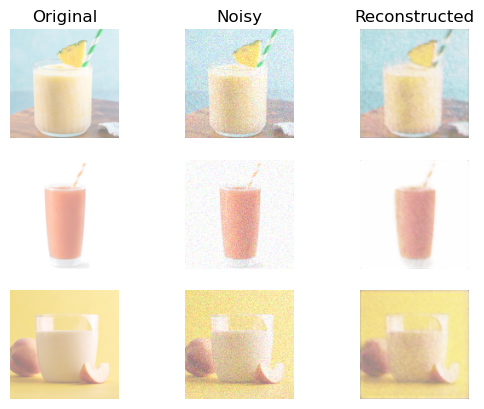

2024-03-03 05:48:26.599018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:27.224995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 161, Loss: 0.004351683193817735


2024-03-03 05:48:27.841657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:28.458807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 162, Loss: 0.0047534448094666


2024-03-03 05:48:29.086140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:29.664185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 163, Loss: 0.004332179902121425


2024-03-03 05:48:30.230195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:30.833100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 164, Loss: 0.00433628773316741


2024-03-03 05:48:31.390447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:31.973083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 165, Loss: 0.004881780594587326


2024-03-03 05:48:32.554632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:33.286064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 166, Loss: 0.004426421131938696


2024-03-03 05:48:34.026663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:34.627035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 167, Loss: 0.004588973009958863


2024-03-03 05:48:35.208092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:35.885468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 168, Loss: 0.004765146877616644


2024-03-03 05:48:36.493605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:37.127286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 169, Loss: 0.003949106438085437


2024-03-03 05:48:37.770438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:38.368121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 170, Loss: 0.0039981676964089274
1/1 [==============================] - 0s 178ms/step


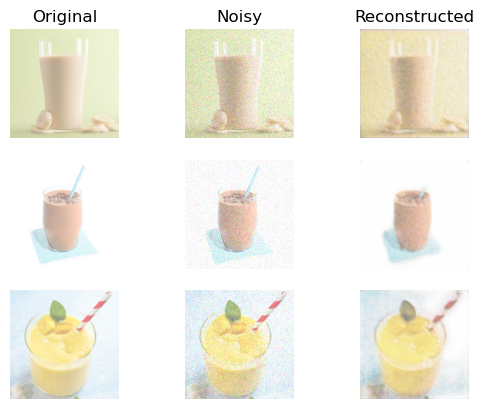

2024-03-03 05:48:39.380421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:40.104844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 171, Loss: 0.004524064250290394


2024-03-03 05:48:40.732582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:41.355159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 172, Loss: 0.004181142430752516


2024-03-03 05:48:41.975871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:42.597861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 173, Loss: 0.0041747922077775


2024-03-03 05:48:43.161992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:43.733597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 174, Loss: 0.004387994762510061


2024-03-03 05:48:44.301175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:44.913521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 175, Loss: 0.004965985426679254


2024-03-03 05:48:45.481843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:46.050099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 176, Loss: 0.0043152268044650555


2024-03-03 05:48:46.618083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:47.319019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 177, Loss: 0.0041904577519744635


2024-03-03 05:48:48.032210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:48.679640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 178, Loss: 0.004093584604561329


2024-03-03 05:48:49.274671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:49.870991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 179, Loss: 0.004132977919653058


2024-03-03 05:48:50.516893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:51.152403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 180, Loss: 0.0046835714019834995
1/1 [==============================] - 0s 179ms/step


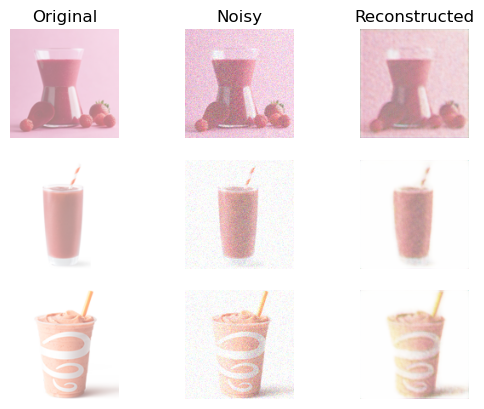

2024-03-03 05:48:52.150028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:52.773551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 181, Loss: 0.004102012841030955


2024-03-03 05:48:53.340301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:53.907902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 182, Loss: 0.004219429101794958


2024-03-03 05:48:54.495962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:55.075103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 183, Loss: 0.004029128351248801


2024-03-03 05:48:55.648221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:56.228249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 184, Loss: 0.004220227478072047


2024-03-03 05:48:56.809842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:57.393905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 185, Loss: 0.003947425750084221


2024-03-03 05:48:58.153896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:48:58.923226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 186, Loss: 0.004070934723131359


2024-03-03 05:48:59.600915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:00.184550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 187, Loss: 0.0035197546239942312


2024-03-03 05:49:00.803985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:01.436742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 188, Loss: 0.004057506565004587


2024-03-03 05:49:02.069970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:02.712050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 189, Loss: 0.0038988874293863773


2024-03-03 05:49:03.345719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:03.983365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 190, Loss: 0.004002112429589033
1/1 [==============================] - 0s 162ms/step


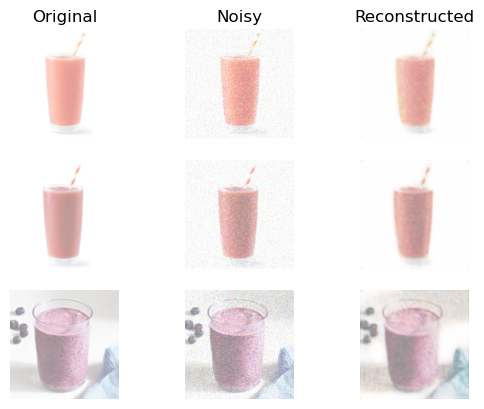

2024-03-03 05:49:04.887518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:05.499828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 191, Loss: 0.004318511579185724


2024-03-03 05:49:06.071531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:06.641769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 192, Loss: 0.004404203966259956


2024-03-03 05:49:07.210922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:07.833100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 193, Loss: 0.0041065014665946364


2024-03-03 05:49:08.465779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:09.050351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 194, Loss: 0.0040126037783920765


2024-03-03 05:49:09.637474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:10.204380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 195, Loss: 0.00447921350132674


2024-03-03 05:49:10.804104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:11.381544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 196, Loss: 0.003808543784543872


2024-03-03 05:49:11.955759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:12.671794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 197, Loss: 0.004151951055973768


2024-03-03 05:49:13.417691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:14.037962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 198, Loss: 0.003566356492228806


2024-03-03 05:49:14.833319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:15.415007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 199, Loss: 0.004180303076282144


2024-03-03 05:49:16.061728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:16.679973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 200, Loss: 0.004407704109326005
1/1 [==============================] - 0s 166ms/step


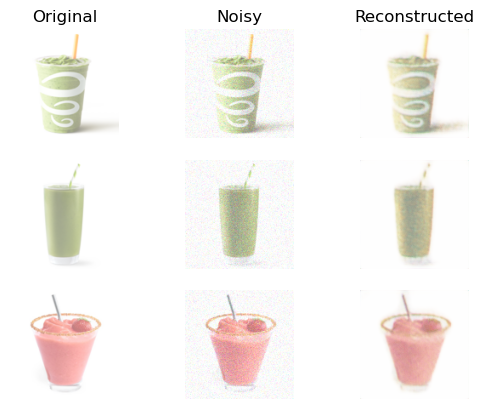

2024-03-03 05:49:17.623199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:18.218752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 201, Loss: 0.004321641870774329


2024-03-03 05:49:18.807588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:19.384245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 202, Loss: 0.004151101456955075


2024-03-03 05:49:19.997947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:20.570373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 203, Loss: 0.0038074280600994825


2024-03-03 05:49:21.136703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:21.705922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 204, Loss: 0.004104390507563949


2024-03-03 05:49:22.410786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:23.249632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 205, Loss: 0.0040252035250887275


2024-03-03 05:49:23.848292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:24.450279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 206, Loss: 0.0037714531645178795


2024-03-03 05:49:25.101711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:25.723189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 207, Loss: 0.0037825923645868897


2024-03-03 05:49:26.339720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:26.985185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 208, Loss: 0.003316989284940064


2024-03-03 05:49:27.614715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:28.218231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 209, Loss: 0.00400117039680481


2024-03-03 05:49:28.855663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:29.465338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 210, Loss: 0.0039352294988930225
1/1 [==============================] - 0s 169ms/step


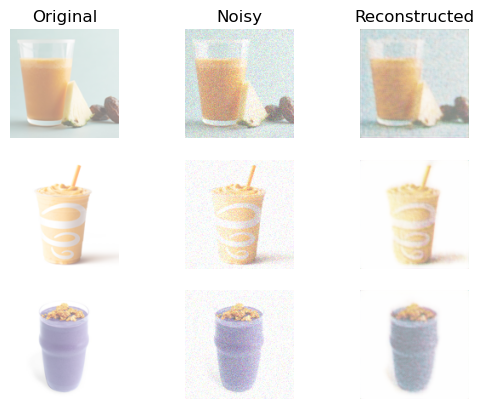

2024-03-03 05:49:30.506737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:31.110812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 211, Loss: 0.0039238526951521635


2024-03-03 05:49:31.710198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:32.286967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 212, Loss: 0.0036698844050988555


2024-03-03 05:49:32.886197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:33.450216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 213, Loss: 0.0036451229825615883


2024-03-03 05:49:34.028134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:34.614307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 214, Loss: 0.00386815145611763


2024-03-03 05:49:35.465899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:36.317405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 215, Loss: 0.0037555539747700095


2024-03-03 05:49:36.906346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:37.495537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 216, Loss: 0.003681184141896665


2024-03-03 05:49:38.106025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:38.738513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 217, Loss: 0.004076999495737255


2024-03-03 05:49:39.354306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:39.938394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 218, Loss: 0.004030207637697458


2024-03-03 05:49:40.522098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:41.119753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 219, Loss: 0.00382049020845443


2024-03-03 05:49:41.701025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:42.304309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 220, Loss: 0.0035857256734743714
1/1 [==============================] - 0s 161ms/step


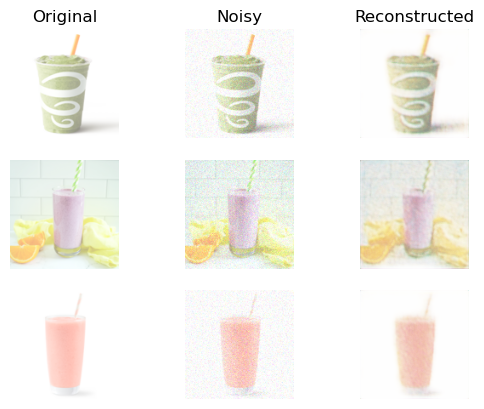

2024-03-03 05:49:43.233029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:43.832014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 221, Loss: 0.0037713157944381237


2024-03-03 05:49:44.447640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:45.017839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 222, Loss: 0.0031295944936573505


2024-03-03 05:49:45.585073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:46.213467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 223, Loss: 0.0038001175271347165


2024-03-03 05:49:46.845471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:47.426206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 224, Loss: 0.0038051955634728074


2024-03-03 05:49:47.992466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:48.611191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 225, Loss: 0.0038926550187170506


2024-03-03 05:49:49.203188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:49.805620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 226, Loss: 0.0032835850724950433


2024-03-03 05:49:50.377379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:50.946685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 227, Loss: 0.0033710768911987543


2024-03-03 05:49:51.520192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:52.126031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 228, Loss: 0.0037662640679627657


2024-03-03 05:49:52.724403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:53.301398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 229, Loss: 0.0036395862698554993


2024-03-03 05:49:53.868200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:54.429576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 230, Loss: 0.0032771441619843245
1/1 [==============================] - 0s 158ms/step


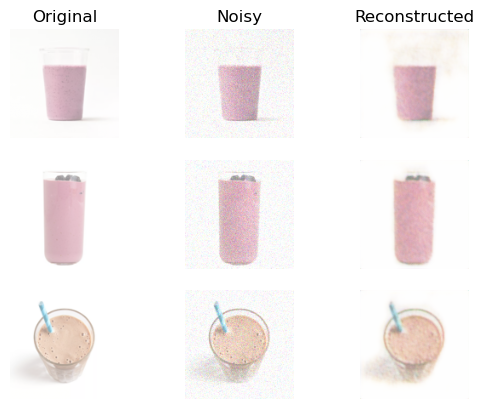

2024-03-03 05:49:55.324031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:55.949115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 231, Loss: 0.0035466542467474937


2024-03-03 05:49:56.571343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:57.157701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 232, Loss: 0.0033819900127127767


2024-03-03 05:49:57.726650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:58.329287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 233, Loss: 0.0036835173377767205


2024-03-03 05:49:58.902576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:49:59.470247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 234, Loss: 0.00348287564702332


2024-03-03 05:50:00.042762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:00.617611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 235, Loss: 0.0035259698051959276


2024-03-03 05:50:01.197596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:02.017888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 236, Loss: 0.0036676141899079084


2024-03-03 05:50:02.943506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:03.544959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 237, Loss: 0.003738841158337891


2024-03-03 05:50:04.138075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:04.728305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 238, Loss: 0.003577440045773983


2024-03-03 05:50:05.374773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:05.963870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 239, Loss: 0.0037940001348033547


2024-03-03 05:50:06.538049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:07.172688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 240, Loss: 0.0037663965485990047
1/1 [==============================] - 0s 169ms/step


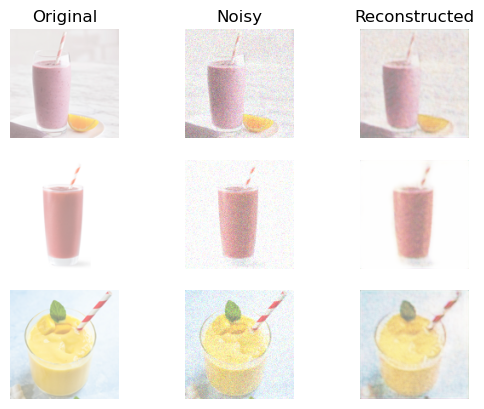

2024-03-03 05:50:08.271692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:08.866853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 241, Loss: 0.0033831626642495394


2024-03-03 05:50:09.474188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:10.048013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 242, Loss: 0.0032523712143301964


2024-03-03 05:50:10.613468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:11.183821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 243, Loss: 0.004031393909826875


2024-03-03 05:50:11.756480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:12.327269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 244, Loss: 0.003097876557148993


2024-03-03 05:50:12.887251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:13.464569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 245, Loss: 0.0034454924752935767


2024-03-03 05:50:14.036666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:14.642839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 246, Loss: 0.003949379199184477


2024-03-03 05:50:15.251332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:15.821355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 247, Loss: 0.003247724031098187


2024-03-03 05:50:16.395629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:17.106466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 248, Loss: 0.00312828307505697


2024-03-03 05:50:17.834608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:18.538753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 249, Loss: 0.0033270863350480795


2024-03-03 05:50:19.157765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:19.769957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 250, Loss: 0.0033973706886172295
1/1 [==============================] - 0s 179ms/step


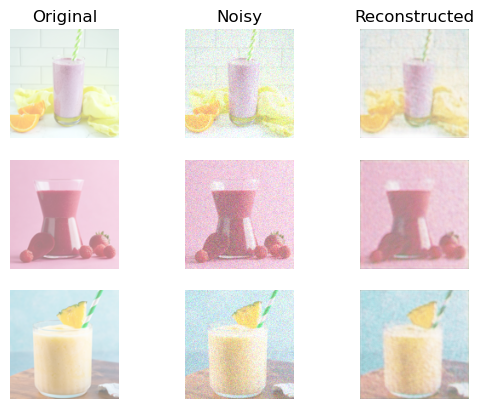

2024-03-03 05:50:20.744352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:21.427113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 251, Loss: 0.003494448959827423


2024-03-03 05:50:22.031688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:22.637850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 252, Loss: 0.003198297810740769


2024-03-03 05:50:23.220269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:23.812351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 253, Loss: 0.003438752144575119


2024-03-03 05:50:24.493689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:25.077143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 254, Loss: 0.003276845789514482


2024-03-03 05:50:25.669566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:26.237898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 255, Loss: 0.0034837244311347604


2024-03-03 05:50:26.819366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:27.532302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 256, Loss: 0.003372059320099652


2024-03-03 05:50:28.266111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:28.887137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 257, Loss: 0.0033384235575795174


2024-03-03 05:50:29.483766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:30.148826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 258, Loss: 0.0030996135901659727


2024-03-03 05:50:30.793581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:31.402349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 259, Loss: 0.0030901068821549416


2024-03-03 05:50:32.037883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:32.662269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 260, Loss: 0.0033585740020498633
1/1 [==============================] - 0s 161ms/step


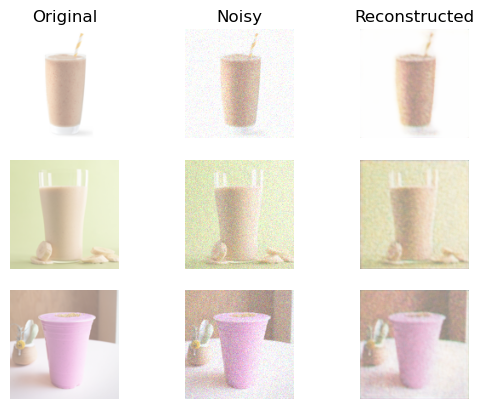

2024-03-03 05:50:33.616285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:34.235345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 261, Loss: 0.0031414531404152513


2024-03-03 05:50:34.836893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:35.417665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 262, Loss: 0.003379362286068499


2024-03-03 05:50:35.986437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:36.550543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 263, Loss: 0.0035891024162992835


2024-03-03 05:50:37.133223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:37.701395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 264, Loss: 0.0030947087798267603


2024-03-03 05:50:38.268045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:38.834586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 265, Loss: 0.0032022050581872463


2024-03-03 05:50:39.395477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:40.085707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 266, Loss: 0.003188390051946044


2024-03-03 05:50:40.896521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:41.509307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 267, Loss: 0.002812296850606799


2024-03-03 05:50:42.064023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:42.657712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 268, Loss: 0.0033946585608646274


2024-03-03 05:50:43.255462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:43.863860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 269, Loss: 0.0031626170966774225


2024-03-03 05:50:44.520197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:45.179375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 270, Loss: 0.003088213037699461
1/1 [==============================] - 0s 164ms/step


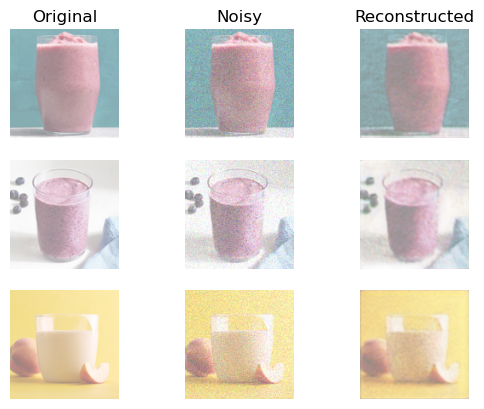

2024-03-03 05:50:46.256548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:46.876722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 271, Loss: 0.003392056212760508


2024-03-03 05:50:47.544669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:48.178814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 272, Loss: 0.0031417072750627995


2024-03-03 05:50:48.813878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:49.406413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 273, Loss: 0.0033269445411860943


2024-03-03 05:50:49.982555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:50.573872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 274, Loss: 0.002912888885475695


2024-03-03 05:50:51.288752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:52.018249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 275, Loss: 0.003355950699187815


2024-03-03 05:50:52.613486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:53.285861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 276, Loss: 0.00337810255587101


2024-03-03 05:50:53.868792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:54.547401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 277, Loss: 0.0030140592716634274


2024-03-03 05:50:55.169958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:55.819628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 278, Loss: 0.003260105731897056


2024-03-03 05:50:56.417676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:57.022140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 279, Loss: 0.0034589022397994995


2024-03-03 05:50:57.598057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:58.218922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 280, Loss: 0.0029528519371524453
1/1 [==============================] - 0s 158ms/step


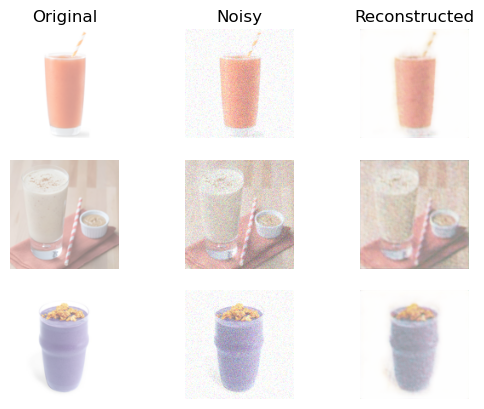

2024-03-03 05:50:59.124281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:50:59.731390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 281, Loss: 0.0032054533949121833


2024-03-03 05:51:00.343986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:00.936770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 282, Loss: 0.003377578337676823


2024-03-03 05:51:01.519329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:02.111282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 283, Loss: 0.00351825135294348


2024-03-03 05:51:02.682836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:03.263366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 284, Loss: 0.0033882649149745703


2024-03-03 05:51:03.841075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:04.437965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 285, Loss: 0.0031031396938487887


2024-03-03 05:51:05.046281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:05.660090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 286, Loss: 0.003126665949821472


2024-03-03 05:51:06.318022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:06.915330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 287, Loss: 0.0030673296423628926


2024-03-03 05:51:07.525900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:08.091477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 288, Loss: 0.0030501167057082057


2024-03-03 05:51:08.670568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:09.254896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 289, Loss: 0.0030463864095509052


2024-03-03 05:51:09.837636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:10.579203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 290, Loss: 0.002957646269351244
1/1 [==============================] - 0s 160ms/step


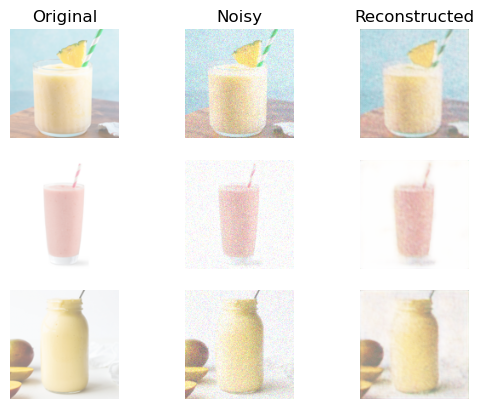

2024-03-03 05:51:11.617337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:12.287010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 291, Loss: 0.0030716272303834558


2024-03-03 05:51:12.951237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:13.584097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 292, Loss: 0.0028569757705554366


2024-03-03 05:51:14.224066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:14.845092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 293, Loss: 0.002885470981709659


2024-03-03 05:51:15.433730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:16.057461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 294, Loss: 0.0026963890995830297


2024-03-03 05:51:16.635509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:17.206709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 295, Loss: 0.0025921521009877324


2024-03-03 05:51:17.793257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:18.526636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 296, Loss: 0.002880559186451137


2024-03-03 05:51:19.253040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:19.926147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 297, Loss: 0.002749277395196259


2024-03-03 05:51:20.480688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:21.057155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 298, Loss: 0.0032680151052773


2024-03-03 05:51:21.639348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:22.298316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 299, Loss: 0.002815689891576767


2024-03-03 05:51:22.920551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]
2024-03-03 05:51:23.546328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [32,128,128,3]
	 [[{{node Placeholder/_1}}]]


Epoch 300, Loss: 0.0031637870706617832
1/1 [==============================] - 0s 161ms/step


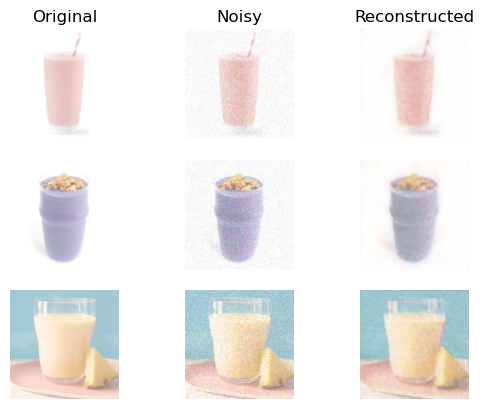

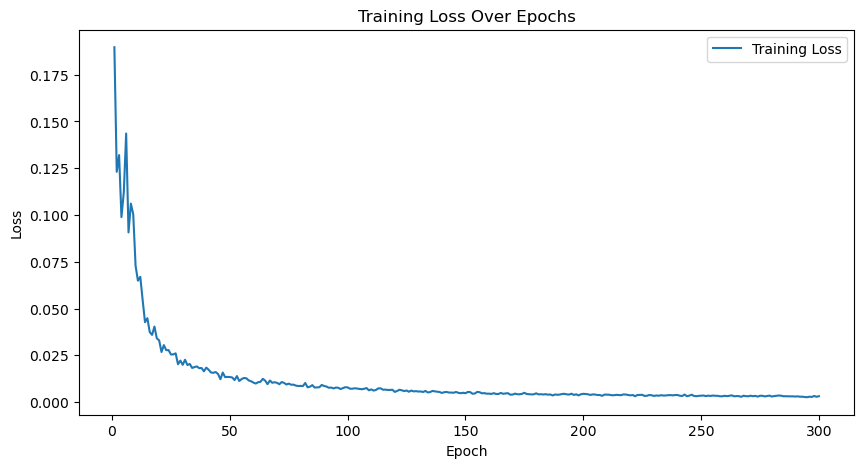

In [66]:
'''Training Execution'''
epochs = 300  # Set the number of epochs. Used to be 50
batch_size = 32  # Set the batch size. Used to be 32
steps_per_epoch = X_train.shape[0] // batch_size  # Assuming X_train is your dataset

# Placeholder for storing training loss
training_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    for step in range(steps_per_epoch):
        # Sample a batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        
        # Apply the forward diffusion process (add noise)
        noisy_images = add_noise(real_images)
        
        # Train the model on this batch
        loss_value = model.train_on_batch(noisy_images, real_images)
        epoch_loss += loss_value
        
    # Calculate average loss for the epoch
    epoch_loss /= steps_per_epoch
    training_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Optionally display some reconstructed images at intervals
    if (epoch + 1) % 10 == 0:
        # Select a random batch of images
        test_idx = np.random.randint(0, X_train.shape[0], batch_size)
        test_images = X_train[test_idx]
        noisy_test_images = add_noise(test_images)
        reconstructed_images = model.predict(noisy_test_images)
        
        # Plot original, noisy, and reconstructed images
        for i in range(3):
            plt.subplot(3, 3, i*3 + 1)
            plt.imshow(test_images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            plt.subplot(3, 3, i*3 + 2)
            plt.imshow(noisy_test_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Noisy')
            plt.subplot(3, 3, i*3 + 3)
            plt.imshow(reconstructed_images[i] * 0.5 + 0.5)
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        plt.show()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### Evaluation and Testing
- Generate images using the trained model and compare them to real images to assess quality.

This cell covers:
- Generating images by feeding noise to the trained model and running the reverse diffusion process.
- Displaying the generated images to visually evaluate how well the model has learned to generate smoothie images.
- Comparing with real images from the dataset for a direct quality assessment.

1/1 [==============================] - 0s 117ms/step


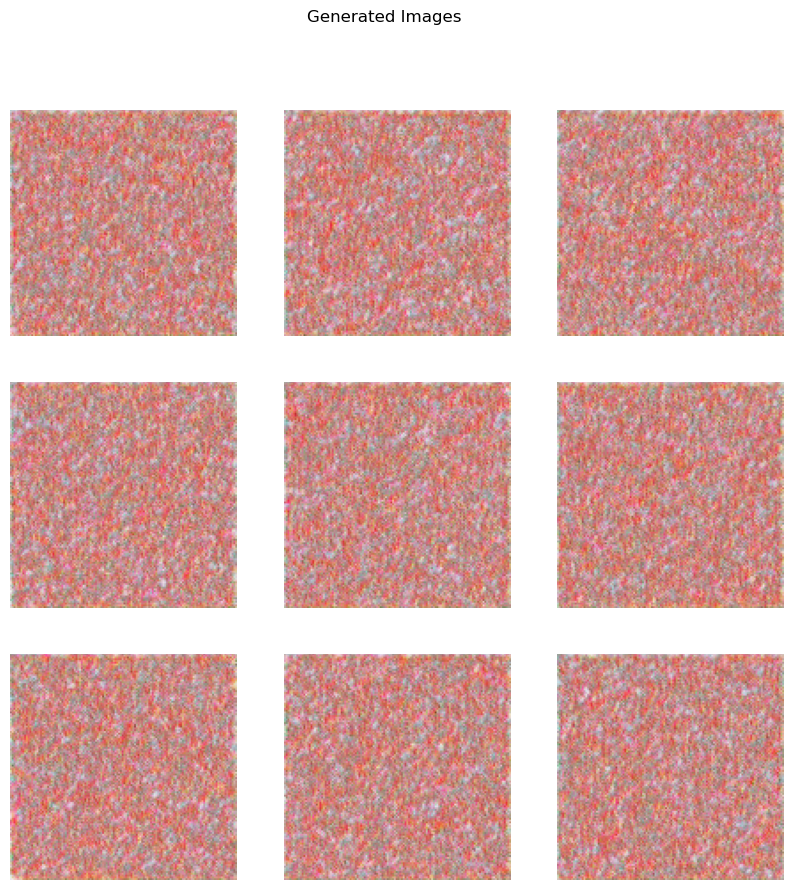

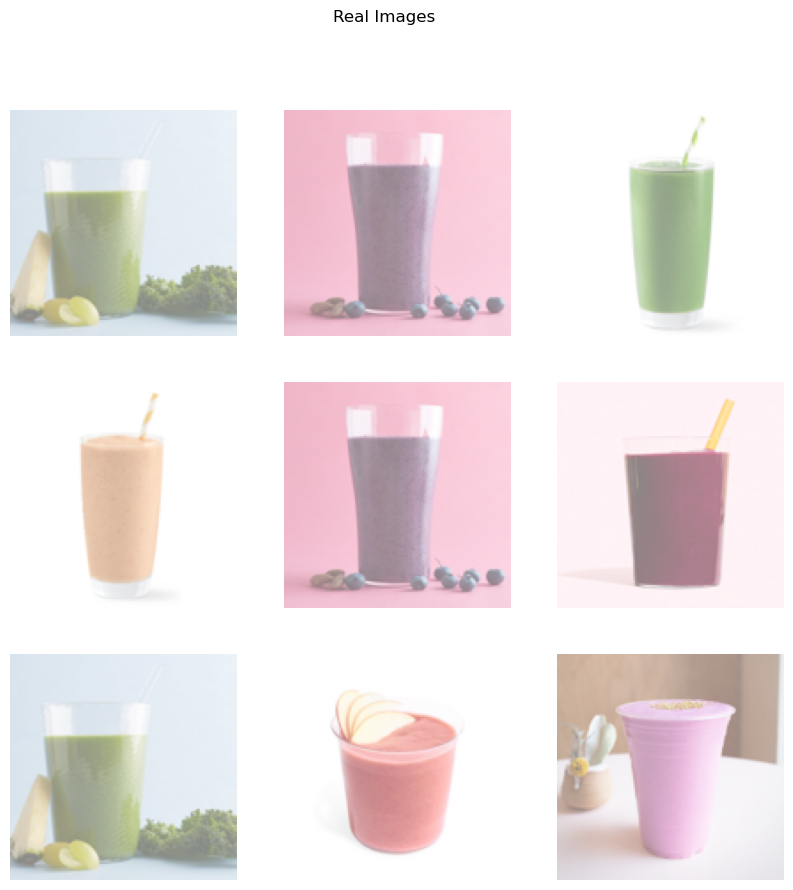

In [67]:
'''Evaluation and Testing'''
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i] * 0.5 + 0.5)  # Assuming images were normalized to [-1, 1]
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Generate images from noise
num_samples = 9  # Number of images to generate
noise = np.random.normal(size=(num_samples, 128, 128, 3))  # Assuming the model inputs are 128x128x3 images
generated_images = model.predict(noise)

# Display generated images
display_images(generated_images, 'Generated Images')

# Optionally, compare with real images from the dataset
# Select a random sample of real images
real_image_indices = np.random.randint(0, X_train.shape[0], num_samples)
real_images = X_train[real_image_indices]

# Display real images
display_images(real_images, 'Real Images')


### Integration Instructions
- Outline how to integrate the model into your Flask application.

To integrate the trained model into your Flask application:
- Save the trained model.
- Load the model in your Flask application.
- Create an endpoint that receives ingredient information, generates a noise vector, and uses the model to generate a smoothie image.
- Return the generated image in response to the request.

In [ ]:
'''Integration Instructions'''
